# **IMPROVED BASELINE MODEL**

**Padding Convolutions**

Adding padding to the convolutional operation can often result in better model performance, as more of the input image of feature maps are given an opportunity to participate or contribute to the output

By default, the convolutional operation uses ‘valid‘ padding, which means that convolutions are only applied where possible. This can be changed to ‘same‘ padding so that zero values are added around the input such that the output has the same size as the input.

In [1]:
# example of loading the fashion mnist dataset
import numpy as npg

from matplotlib import pyplot
from keras.datasets import fashion_mnist
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.model_selection import KFold
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD



Using TensorFlow backend.


# **Baseline Model**

Ini sangat penting karena keduanya melibatkan pengembangan infrastruktur untuk uji harness sehingga setiap model yang di desain dapat dievaluasi pada dataset, dan ini menetapkan dasar dalam kinerja model pada masalah, yang dengannya semua perbaikan dapat dibandingkan.

Desain harness uji bersifat modular, dan kami dapat mengembangkan fungsi terpisah untuk masing-masing bagian. Ini memungkinkan aspek tertentu dari harness uji untuk dimodifikasi atau diubah, jika diinginkan, terpisah dari yang lain.

Kita dapat mengembangkan alat uji ini dengan lima elemen kunci. Mereka adalah pemuatan dataset, persiapan dataset, definisi model, evaluasi model, dan penyajian hasil.

## **1. Load Dataset**

Data fashion-MNIST adalah data yang berukuran 28x28 pixel dengan warna greyscale. Oleh karena itu kita reshape data array nya untuk mendapatkan single color chanel.

Menggunakan fungsi `to_categorical()` kita akan mentransform integer ke 10 class binary vektor dengan 1 sebagai nilai index class.

In [2]:
# load train and test dataset
def load_dataset():
    # load dataset
    (trainX, trainY), (testX, testY) = fashion_mnist.load_data()
    
    trainX_filtered = []
    trainY_filtered = []
    for x, y in zip(trainX, trainY):
        if y == 0 or y ==1:   
            trainX_filtered.append(x)
            trainY_filtered.append(y)
    
    testX_filtered = []
    testY_filtered = []
    for x, y in zip(testX, testY):
        if y == 0 or y ==1:
            testX_filtered.append(x)
            testY_filtered.append(y)
    
    trainX = np.array(trainX_filtered)
    trainY = np.array(trainY_filtered)
    testX  = np.array(testX_filtered)
    testY  = np.array(testY_filtered)
    
    print(trainX.shape, trainY.shape)
    print(len(trainX_filtered))
    
    # reshape dataset to have a single channel
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX  = testX.reshape((testX.shape[0], 28, 28, 1))
    # one hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    
    return trainX, trainY, testX, testY

## **2. Prepare Pixel Data**

Kita tahu bahwa nilai piksel untuk setiap gambar dalam dataset adalah bilangan bulat yang unsigned dalam rentang antara hitam dan putih, atau 0 dan 255.

Kami tidak tahu cara terbaik untuk skala nilai piksel untuk pemodelan, tetapi kami tahu bahwa bahwa scaling akan diperlukan.

Titik awal yang baik adalah untuk menormalkan nilai piksel gambar skala abu-abu, mis. rescale ke kisaran [0,1]. Ini melibatkan konversi tipe data dari bilangan bulat unsigned menjadi float, kemudian membagi nilai piksel dengan nilai maksimum.

In [3]:
# scale pixels
def prep_pixels(train, test):
    #convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    #return normalized images
    return train_norm, test_norm

Fungsi diatas harus dipanggil untuk menyiapkan nilai piksel sebelum melakukan pemodelan apapun.

## **3. Define Model**

Selanjutnya, kita perlu mendefinisikan model `CNN` untuk masalah ini.

Model ini memiliki dua aspek utama yaitu :
1. **the feature extraction front end comprised of convolutional and pooling layers** - front end feature extraction dari konvolusional dan pooling layers.
2. **the classifier backend that will make a prediction** - classifier backend yang akan membuat prediksi

Untuk `front-end` konvolusional, kita dapat mulai dengan `single convolutional layer` dengan ukuran filter kecil yaitu (3,3) dan sejumlah kecil filter (32) diikuti oleh `max pooling layers`. Peta filter kemudian dapat diratakan untuk memberikan fitur ke classifier.

Mengingat bahwa masalahnya adalah klasifikasi multi-kelas, kita tahu bahwa kita akan memerlukan lapisan output dengan 10 node untuk memprediksi distribusi probabilitas suatu gambar milik masing-masing dari 10 kelas. Ini juga akan memerlukan penggunaan fungsi `softmax activation`. Antara fitur extractor dan layer output, kita bisa menambahkan `dense layer` untuk menginterpretasikan fitur, dalam hal ini kita menggunakan 100 node.

Semua layer akan menggunakan `ReLU` dan `HE Weights` untuk skema inisialisasinya, kedua algoritma ini adalah yang terbaik dalam hal ini.

Kita akan menggunakan konfigurasi konservatif untuk `stochastic gradient descent optimizer` dengan tingkat pembelajaran atau learning rate sebesar 0,01 dan momentum sebesar 0,9. `The categorical cross-entropy loss function` akan dioptimalkan, cocok untuk klasifikasi multi-kelas, dan kita akan memantau metrik akurasi klasifikasi, yang sesuai mengingat kami memiliki jumlah contoh yang sama di masing-masing dari 10 kelas.

In [4]:
# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(2, activation='softmax'))
    #compile model
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

## **4. Evaluate Model**

Setelah model di buat kita perlu mengevaluasi model kita. Model ini akan di evaluasi dengan 5-Fold cross validation. Nilai dari k=5 ini dipilih untuk menyediakan model dasar untuk kedua pengulangan evaluasi dan tidak terlalu besar dan tak memakan waktu. Setiap test set disetel pada 20% training dataset atau sekitar 20.000 contoh gambar, untuk masalah ini mendekati dengan tes set. 

Dataset pelatihan diacak sebelum dipisah dan pengacakan sampel dilakukan setiap kali sehingga model apa pun yang dievaluasi akan memiliki rangkaian data latih dan uji yang sama di setiap layer, ini memberikan perbandingan 1 : 1.

Kita akan melatih model dasar untuk 10 epoch pelatihan sederhana dengan ukuran batch standar sebanyak 32 contoh. Set tes untuk setiap layer akan digunakan untuk mengevaluasi model baik selama setiap epoch itu pelatihan dijalankan, sehingga kita nantinya dapat membuat learning curves, dan pada proses terakhir, sehingga kita dapat memperkirakan kinerja model. Dengan demikian, kitaakan melacak riwayat yang dihasilkan dari setiap proses, serta akurasi klasifikasi dari fold itu.

Fungsi `evaluate_model()` di bawah ini mengimplementasikan perilaku-perilaku ini, menggunakan dataset pelatihan sebagai argumen dan mengembalikan daftar skor akurasi dan riwayat pelatihan yang dapat diringkas kemudian.


In [5]:
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
    scores, histories = list(), list()
    # prepare cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    for train_ix, test_ix in kfold.split(dataX):
        # define model
        model = define_model()
        # select rows for train and test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        # fit model
        history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
        # evaluate model
        _, acc = model.evaluate(testX, testY, verbose=0)
        print('> %.3f' % (acc * 100.0))
        # append scores
        scores.append(acc)
        histories.append(history)
    return scores, histories

# **5. Present Result**

Setelah model dibuat dan dievaluasi kita akan melihat hasilnya. Ada 2 aspek yang akan dilihat yaitu :
1. Diagnosa learning behaviour dari model saat training
2. Estimasi dari performa model
keduanya bisa di implementasikan menggunakan fungsi terpisah. 

Pertama, diagnostic melibatkan pembuatan line plot yang menampilkan training dan test set saat fold dari cross-validation fold. Plot ini sangat berharga untuk mengerti apakah model kita `overfittig`, `underfitting`, atau punya `good-fit` untuk dataset tersebut.

Kita akan membuat single-figure dengan 2 subplot :
1. Akurasi
2. loss

Garis biru akan mengindikasikan performa model di training dataset dan garis oranye akan menunjukkan kinerja dari hold-out test. Fungsi `summarize_diagnostic()` dibawah ini akan membuat dan menunjukkan plot history training yang dikumpulkan

In [6]:
# plot diagnostic learning curves
def summarize_diagnostics(histories):
    for i in range(len(histories)):
        # plot loss
        pyplot.subplot(211)
        pyplot.title('Cross Entropy Loss')
        pyplot.plot(histories[i].history['loss'], color='blue', label='train')
        pyplot.plot(histories[i].history['val_loss'], color='orange', label='test')
        # plot accuracy
        pyplot.subplot(212)
        pyplot.title('Classification Accuracy')
        pyplot.plot(histories[i].history['accuracy'], color='blue', label='train')
        pyplot.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    pyplot.show()

In [7]:
# summarize model performance
def summarize_performance(scores):
    # print summary
    print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
    # box and whisker plots of results
    pyplot.boxplot(scores)
    pyplot.show()

(12000, 28, 28) (12000,)
12000
> 99.208
> 99.542
> 99.542
> 99.250
> 99.667


C:\Users\Gustian\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
C:\Users\Gustian\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Gustian\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: M

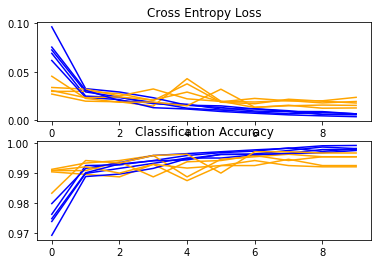

Accuracy: mean=99.442 std=0.180, n=5


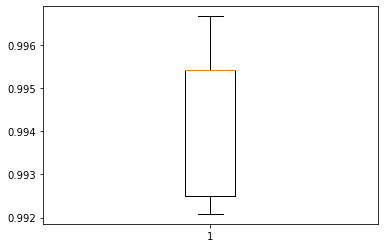

In [8]:
import numpy as np

# run the test harness for evaluating a model
def run_test_harness():
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    # prepare pixel data
    trainX, testX = prep_pixels(trainX, testX)
    # evaluate model
    scores, histories = evaluate_model(trainX, trainY)
    # learning curves
    summarize_diagnostics(histories)
    # summarize estimated performance
    summarize_performance(scores)
    
# entry point, run the test harness
run_test_harness()

Dalam hal ini, kita dapat melihat bahwa model umumnya mencapai kecocokan yang baik, dengan konvergensi kurva test dan train. Mungkin ada beberapa tanda sedikit overfitting.

Akhirnya, sebuah box dan whisker plot telah dibuat untuk menyederhhanakan distribusi dari skor akurasi. 

Sekarang kita punya sebuah test harness yang kuat dan model baseline yang baik.

# **6. Save Final Model**


In [14]:
# save the final model to file
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
 
# load train and test dataset
def load_dataset():
    # load dataset
    (trainX, trainY), (testX, testY) = fashion_mnist.load_data()
    trainX_filtered = []
    trainY_filtered = []
    for x, y in zip(trainX, trainY):
        if y == 0 or y ==1:   
            trainX_filtered.append(x)
            trainY_filtered.append(y)
    
    testX_filtered = []
    testY_filtered = []
    for x, y in zip(testX, testY):
        if y == 0 or y ==1:
            testX_filtered.append(x)
            testY_filtered.append(y)
    
    trainX = np.array(trainX_filtered)
    trainY = np.array(trainY_filtered)
    testX  = np.array(testX_filtered)
    testY  = np.array(testY_filtered)
    
    # reshape dataset to have a single channel
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))
    # one hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY
 
# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm
 
# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(2, activation='softmax'))
	# compile model
	opt = SGD(lr=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model
 
# run the test harness for evaluating a model
def run_test_harness():
	# load dataset
	trainX, trainY, testX, testY = load_dataset()
	# prepare pixel data
	trainX, testX = prep_pixels(trainX, testX)
	# define model
	model = define_model()
	# fit model
	model.fit(trainX, trainY, epochs=10, batch_size=32, verbose=0)
	# save model
	model.save('binary_final_model.h5')
 
# entry point, run the test harness
run_test_harness()